In [2]:
import pandas as pd
import numpy as np
from datetime import timedelta
from strfdelta import strfdelta
from glob import glob
from re import findall
from matplotlib import pyplot as plt
from IPython.display import display, HTML

In [26]:
sourceDirs = [
    ('./1', 39, 8.888888889),
    ('./2', 358, 3.80952381),
    ('./3', 13, 3.80952381)
]

In [27]:
def getCsvsFromDir(srcDir: str):
    for path in glob(srcDir+'/n*.csv'):
        data = pd.read_csv(path)

        iters = int(findall("n(\d+)\.csv", path)[0])

        yield data, iters

In [32]:
inline = True
if not inline:
    %matplotlib qt
else:
    %matplotlib inline

In [35]:
for sourceDir, idealSteps, tauEnd in sourceDirs:
    plotData = []

    arduino = [ a for a in getCsvsFromDir(sourceDir) ]

    for data, iters in arduino:
        gb = data.groupby('cycle')

        # get the final temp of last cycle (the one with the highest ambient temp)
        plotData.append([iters, *gb.last().iloc[-1][['tempIn', 'tempOut', 'tempAmb']]])

    data = pd.DataFrame(plotData)
    data.columns = ['iters', 'in', 'out', 'amb']

    data.sort_values('iters', inplace=True, ascending=False)

    fig = plt.figure("finalna " + sourceDir)
    plt.title("Temperatury końcowe")
    plt.grid()
    lines = plt.plot(data['iters'], data[['in', 'out', 'amb']])
    plt.axvline(x=idealSteps, color='red', linewidth=1)

    plt.xlim(data['iters'].min(), data['iters'].max())

    plt.xlabel('Ilość kroków czasowych')
    plt.ylabel('T emperatura [°C]')

    ax = fig.axes[0]
    ax.legend(
        lines,
        [
            'T emp. wewnętrzna',
            'T emp. zewnętrzna',
            'T emp. pieca'
        ],
        loc='lower center',
        fancybox=True,
        ncol=3,
        bbox_to_anchor=(0.5, -.31)
    )

    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.15, box.width, box.height*0.85])

    pc = [a for a in getCsvsFromDir(sourceDir+'PC')]

    for (data, iters) in pc:
        data.columns = [col.strip() for col in data.columns]

    table = pd.DataFrame(
        [
            [
                iters,
                tauEnd/iters,
                ardData.groupby('cycle').sum()['arduinoDurationMicros'].mean(),
                pcData.groupby('cycle').sum()['arduinoDurationMicros'].mean()
            ] for (ardData, iters), (pcData, _) in zip(arduino, pc)
        ]
    )

    table.columns = ['Kroki', 'Δτ [s]', 'Arduino', 'PC']
    mean = (table['Arduino'] / table['PC']).mean()
    table[['Arduino', 'PC']] = table[['Arduino', 'PC']].applymap(lambda x: strfdelta(timedelta(microseconds=x), '{S}s {m}ms {u}µs'))
    table.sort_values('Kroki', inplace=True)

    display(HTML(table.to_html(index=False)))
    print(f"Arduino/PC średnia: {mean:.{0}f}")

Kroki,Δτ [s],Arduino,PC
5,1.777778,0s 174ms 301µs,0s 0ms 26µs
10,0.888889,0s 319ms 718µs,0s 0ms 55µs
20,0.444444,0s 609ms 878µs,0s 0ms 115µs
30,0.296296,0s 897ms 893µs,0s 0ms 182µs
39,0.227920,1s 156ms 860µs,0s 0ms 202µs
50,0.177778,1s 475ms 203µs,0s 0ms 276µs
75,0.118519,2s 196ms 500µs,0s 0ms 382µs
100,0.088889,2s 921ms 994µs,0s 0ms 506µs
125,0.071111,3s 645ms 193µs,0s 0ms 638µs
150,0.059259,4s 362ms 838µs,0s 0ms 758µs


Arduino/PC średnia: 5677


Kroki,Δτ [s],Arduino,PC
200,0.019048,11s 494ms 166µs,0s 1ms 49µs
225,0.016931,12s 917ms 732µs,0s 1ms 320µs
250,0.015238,14s 331ms 894µs,0s 1ms 318µs
275,0.013853,15s 759ms 556µs,0s 1ms 584µs
300,0.012698,17s 156ms 193µs,0s 1ms 547µs
325,0.011722,18s 579ms 957µs,0s 1ms 652µs
350,0.010884,20s 0ms 198µs,0s 1ms 826µs
358,0.010641,20s 457ms 733µs,0s 1ms 968µs
375,0.010159,21s 427ms 202µs,0s 2ms 244µs
400,0.009524,22s 852ms 365µs,0s 2ms 194µs


Arduino/PC średnia: 10522


Kroki,Δτ [s],Arduino,PC
4,0.952381,0s 58ms 883µs,0s 0ms 21µs
6,0.634921,0s 82ms 453µs,0s 0ms 306µs
8,0.476190,0s 105ms 406µs,0s 0ms 580µs
10,0.380952,0s 128ms 805µs,0s 0ms 51µs
13,0.293040,0s 164ms 13µs,0s 0ms 66µs
15,0.253968,0s 187ms 386µs,0s 0ms 76µs
20,0.190476,0s 245ms 511µs,0s 0ms 102µs
30,0.126984,0s 362ms 604µs,0s 0ms 157µs
40,0.095238,0s 479ms 182µs,0s 0ms 201µs
50,0.076190,0s 597ms 224µs,0s 0ms 37µs


Arduino/PC średnia: 4711


(0.0, 199.99896240234372)

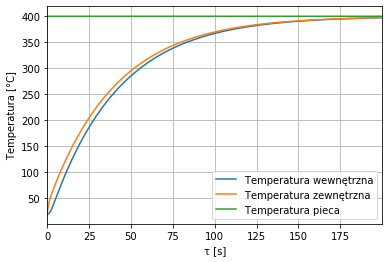

In [30]:
dlugieData = pd.read_csv('./dlugie.csv')

dlugieData.sort_values('tau', inplace=True)

plt.figure('Weryfikacja')
plt.plot(dlugieData['tau'], dlugieData[['tempIn', 'tempOut', 'tempAmb']])
plt.grid()
plt.legend(lines, ['T emperatura wewnętrzna', 'T emperatura zewnętrzna', 'T emperatura pieca'])
plt.xlabel("τ [s]")
plt.ylabel("T emperatura [°C]")
plt.xlim(0, dlugieData['tau'].max())